# Feature Importance and Regression Models

11 features for which feataure importance has been calculated using Random Forest
1. finishedsquarefeet13
2. finishedsquarefeet15
3. finishedsquarefeet6
4. garagecarcnt
5. garagetotalsqft
6. heatingorsystemtypeid
7. landtaxvaluedollarcnt
8. numberofstories
9. taxamount
10. taxvaluedollarcnt
11. unitcnt

The random forest training was run on AWS and the results have been imported back as csv. 

In this notebook, each target feature, a polynomial regression model is fit using the most important features. The number of features for each training is subjective to individual feature

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sets import Set

color = sns.color_palette()
%matplotlib inline

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: the sets module is deprecated


Importing Data

In [2]:
df = pd.read_pickle("train_df_partial_filled.pkl")
df.shape

(3064055, 60)

Creating feature importance dataframes for each target feature

In [29]:
path = "./feature_importance/"
feature_list = []
filenames = []
importance_dfs = []
for filename in glob(path + "*.csv"):
    filenames.append(filename)
    # WINDOWS
    feature = filename.split(".")[-2].split("\\")[-1]
    # LINUX
    #feature = filename.split(".")[-2].split("/")[-1]    
    feature_list.append(feature)
    df2 = pd.read_csv(filename)
    importance_dfs.append(df2)
    

# 1. Plotting feature importance for each target variable

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


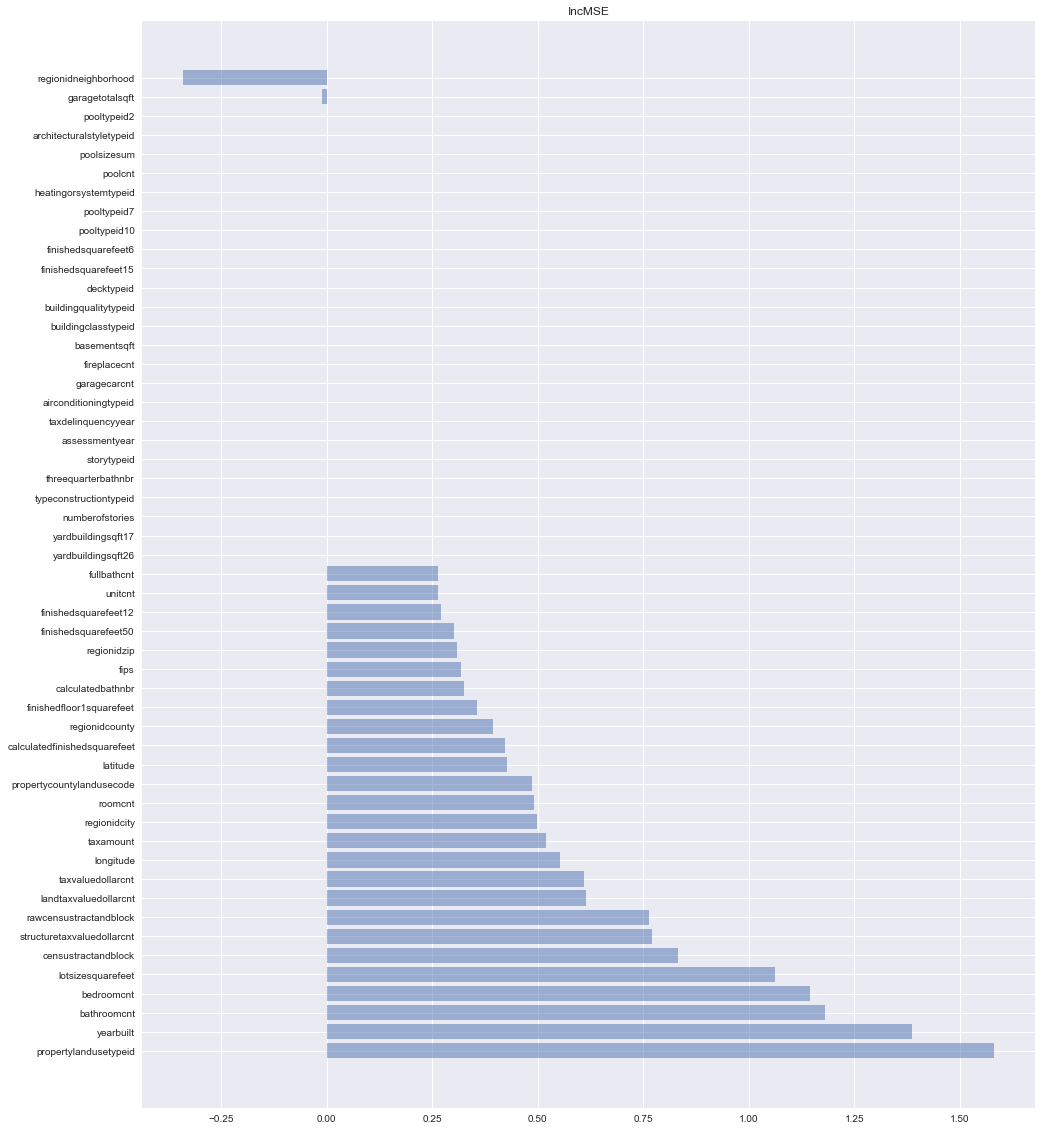

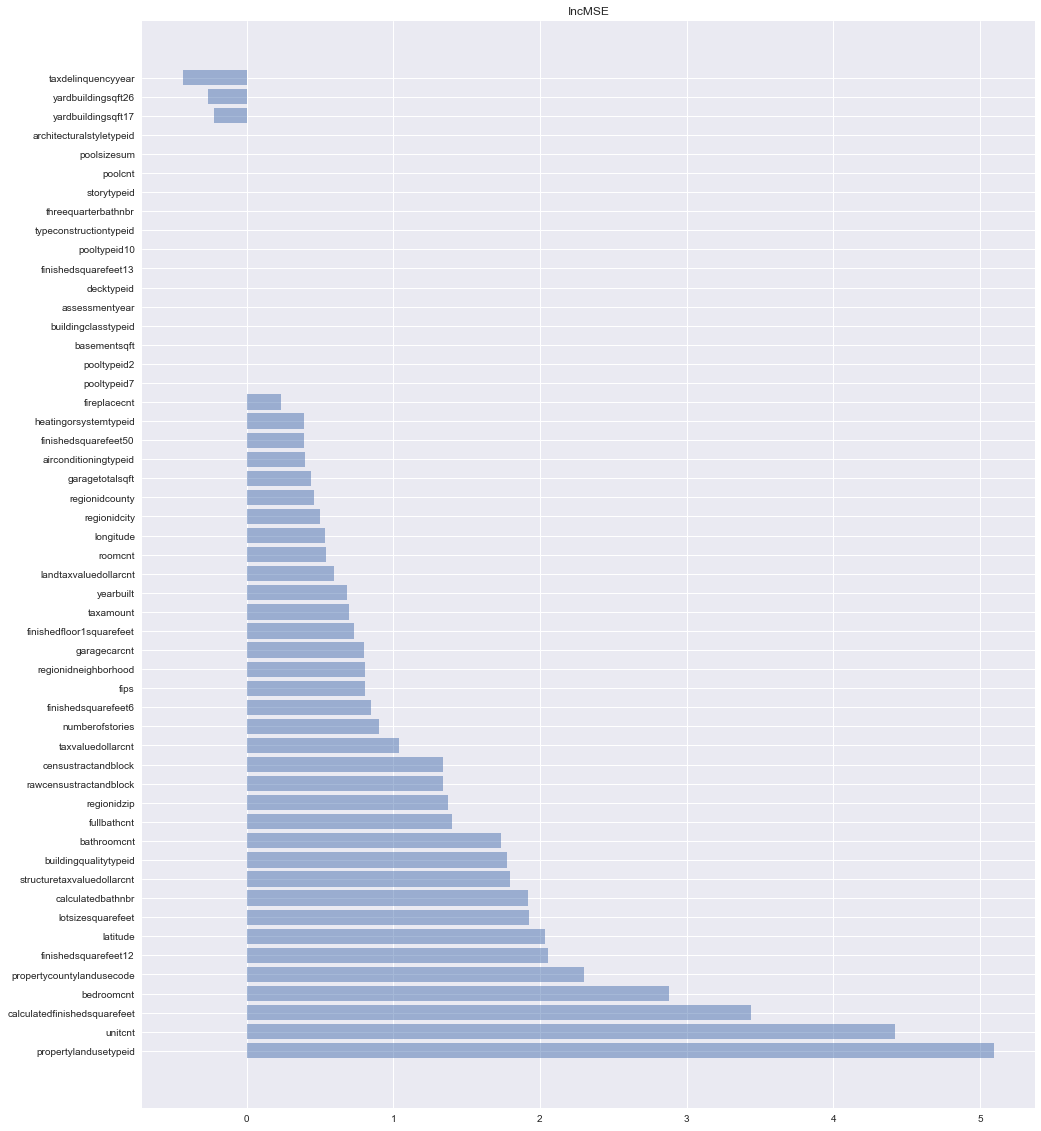

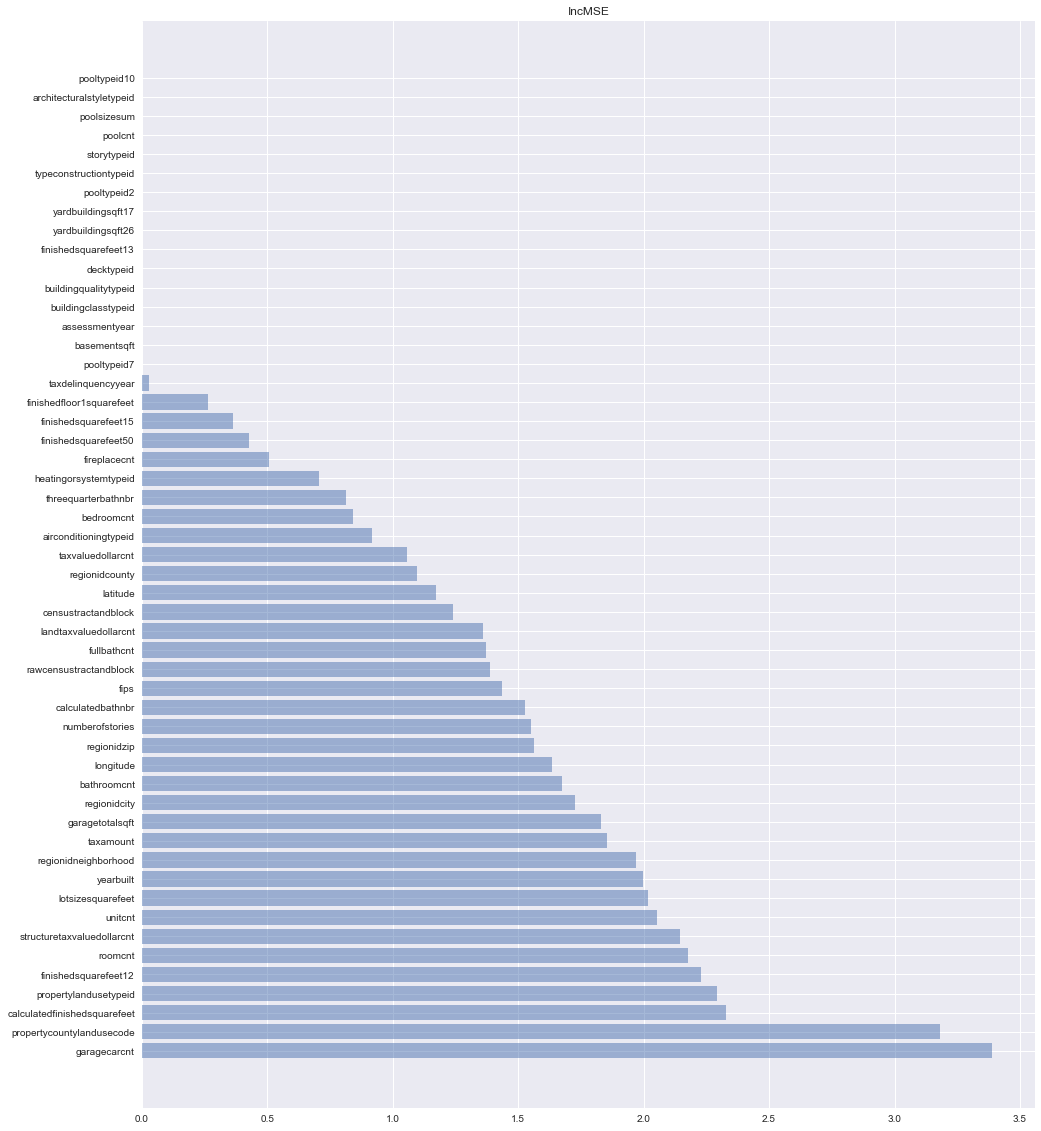

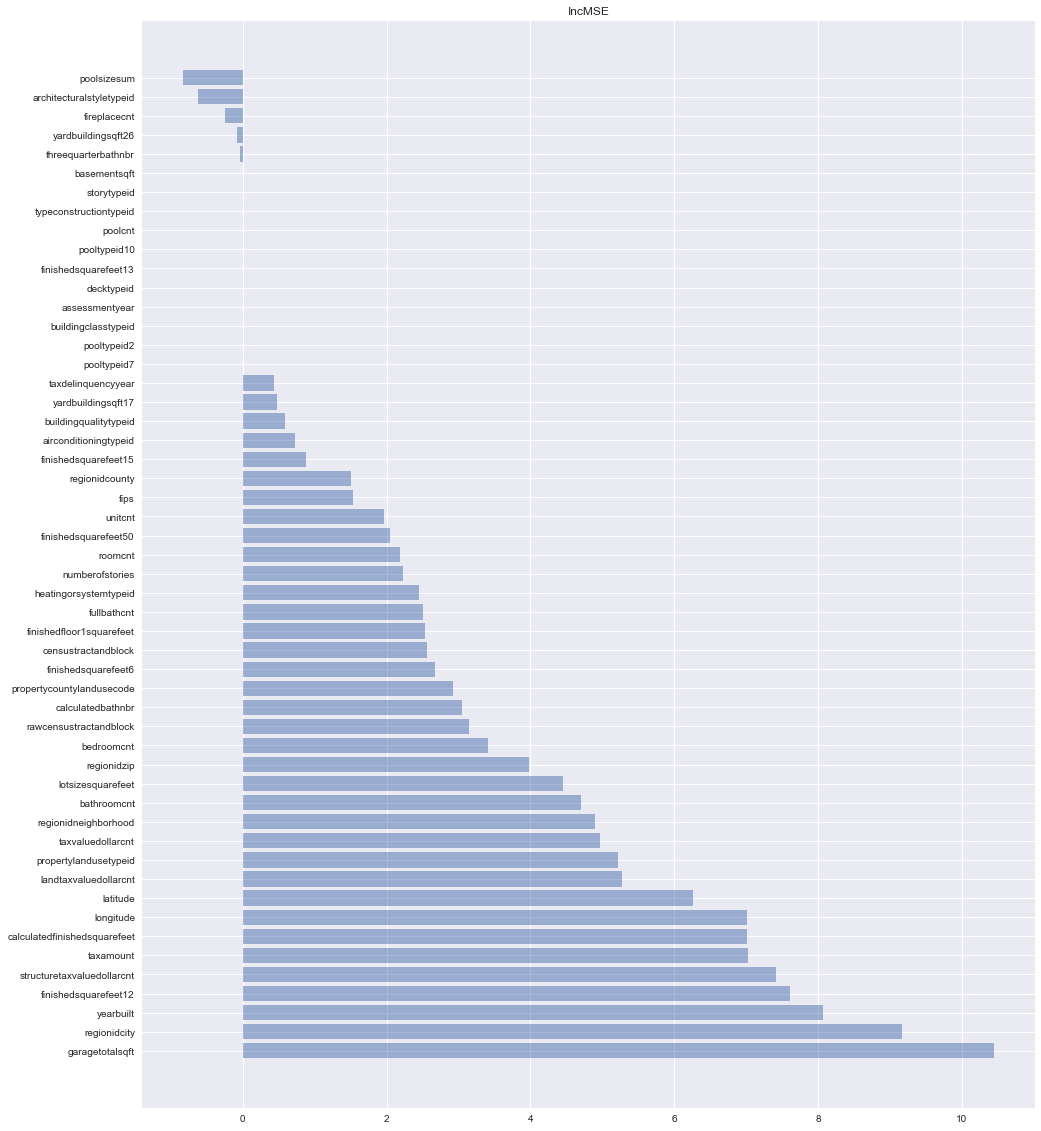

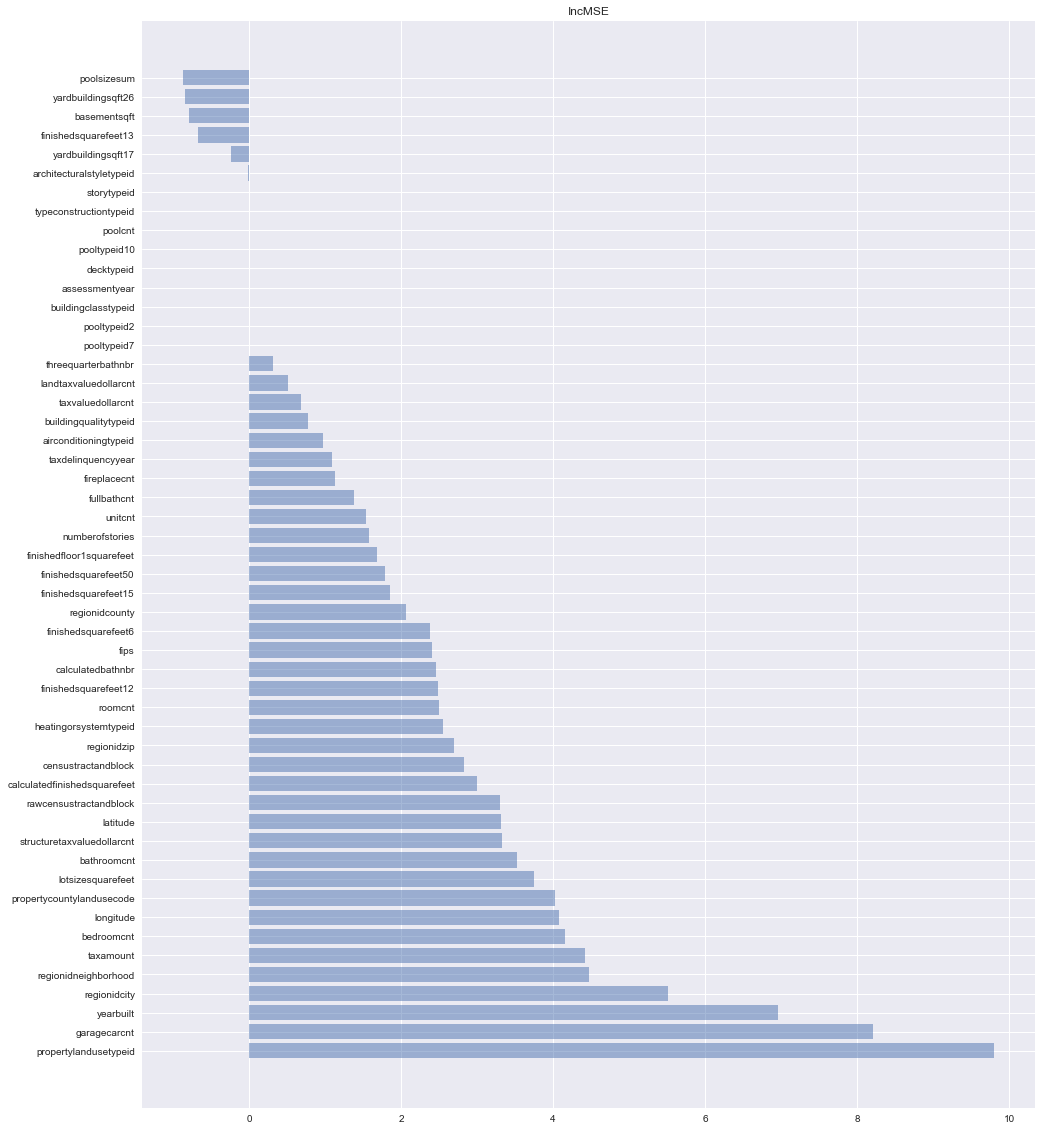

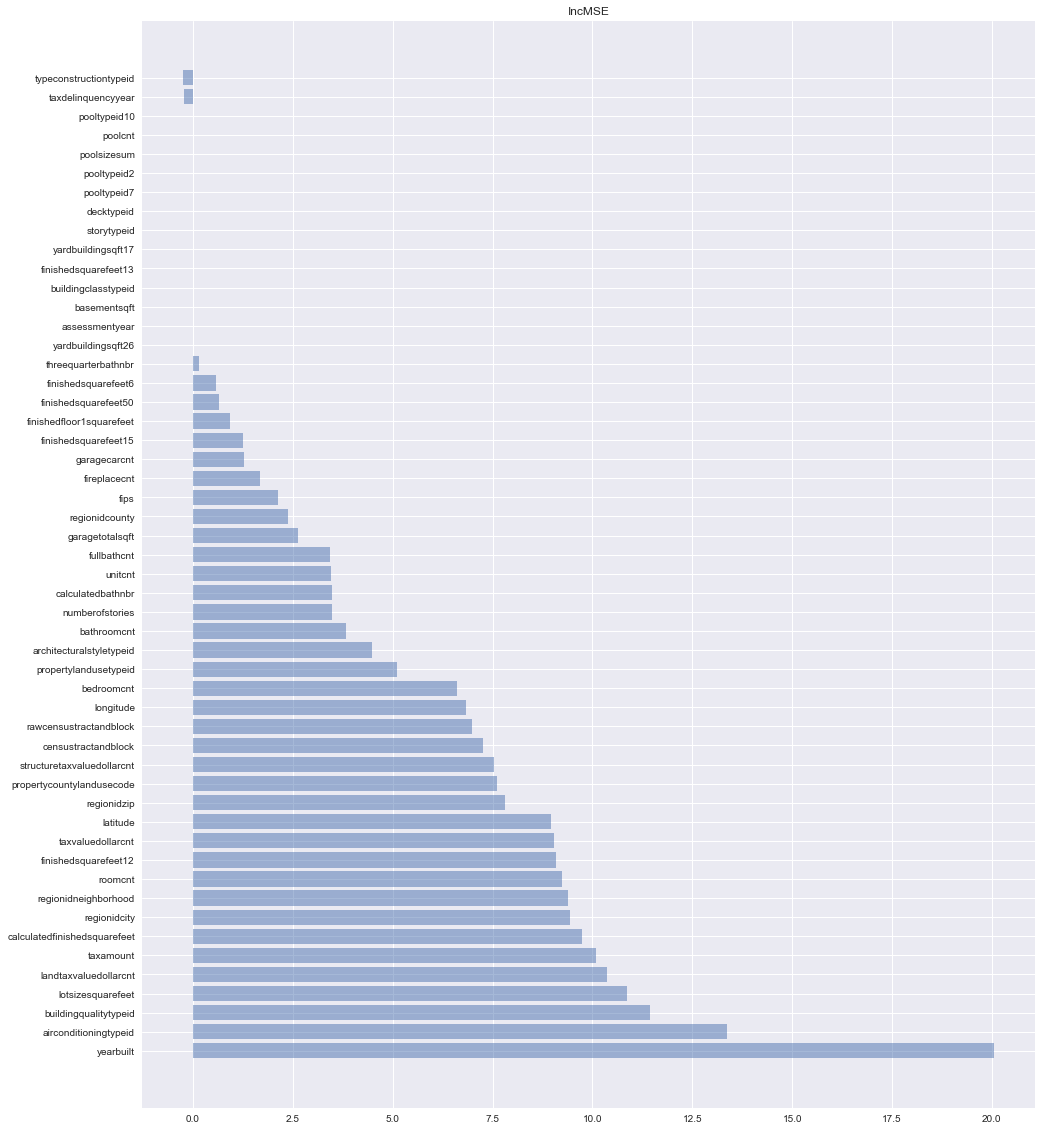

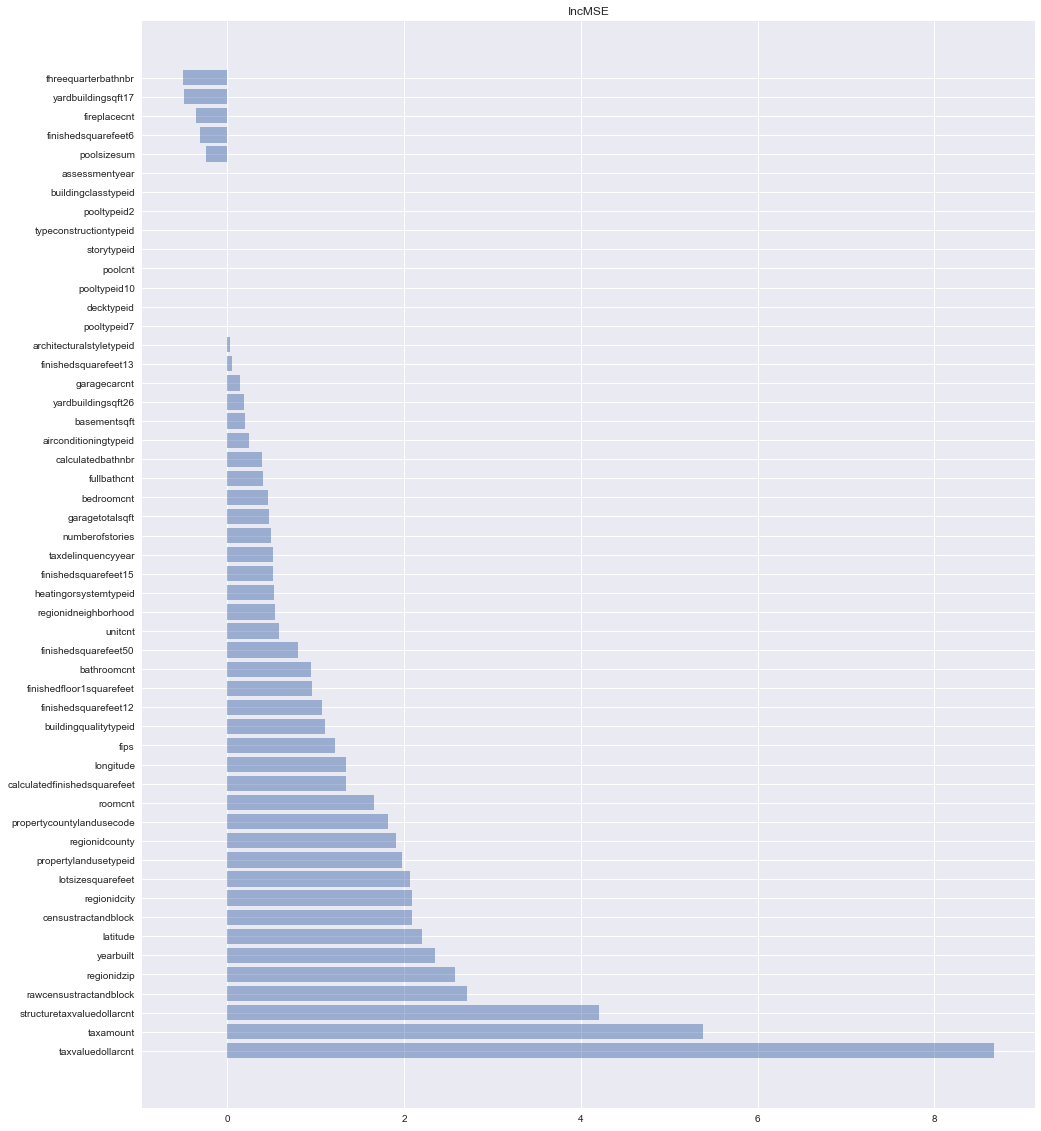

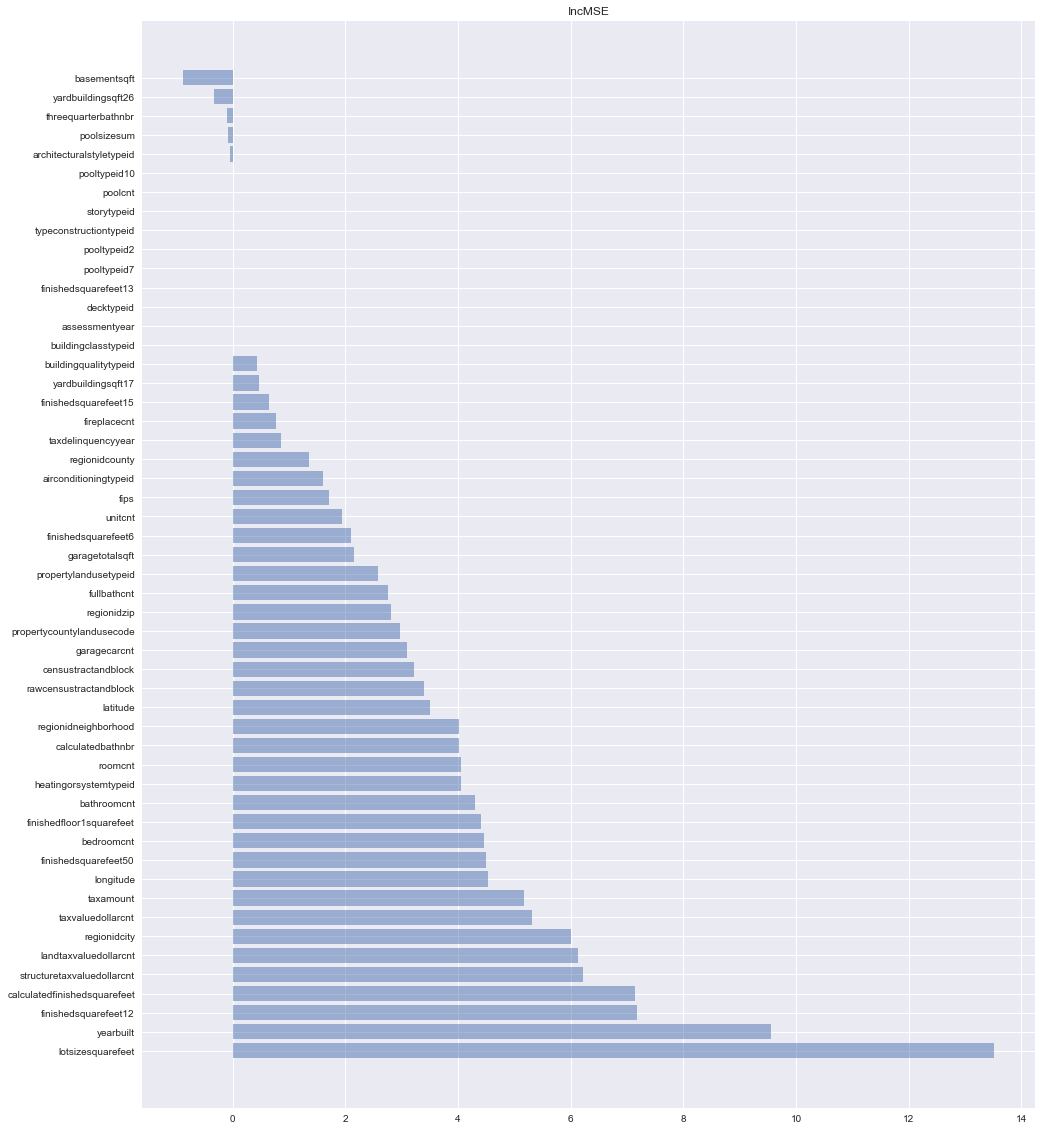

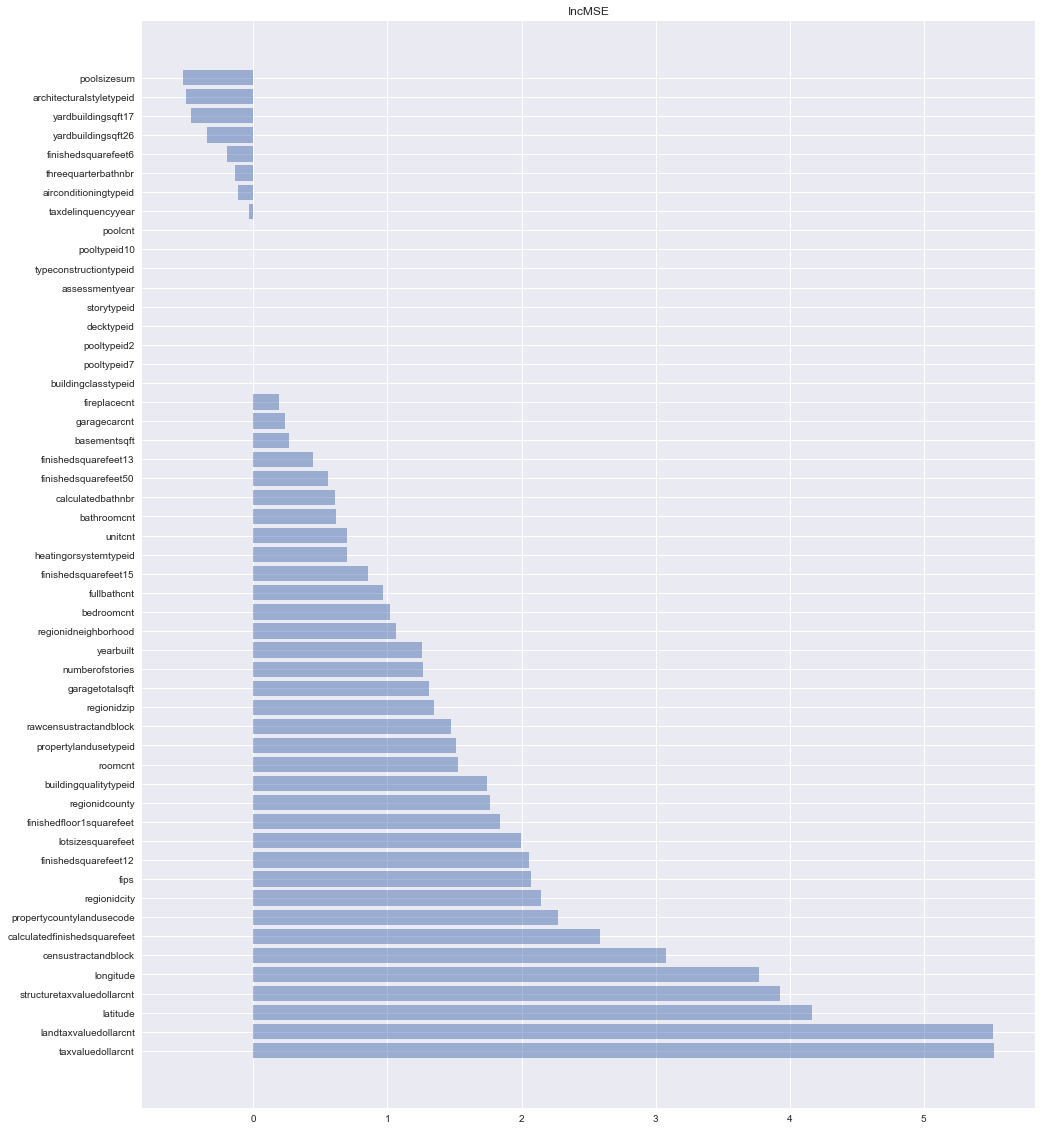

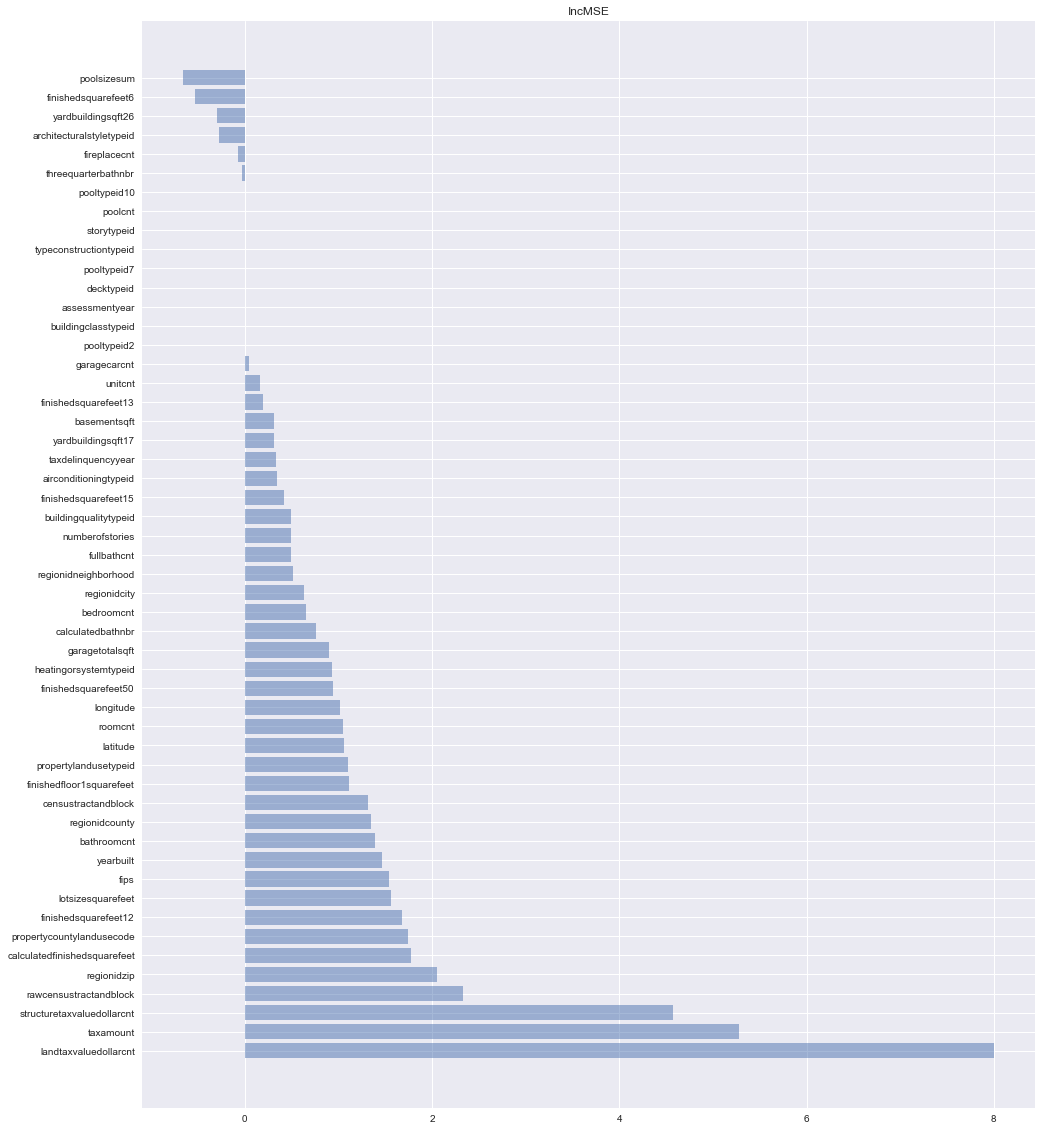

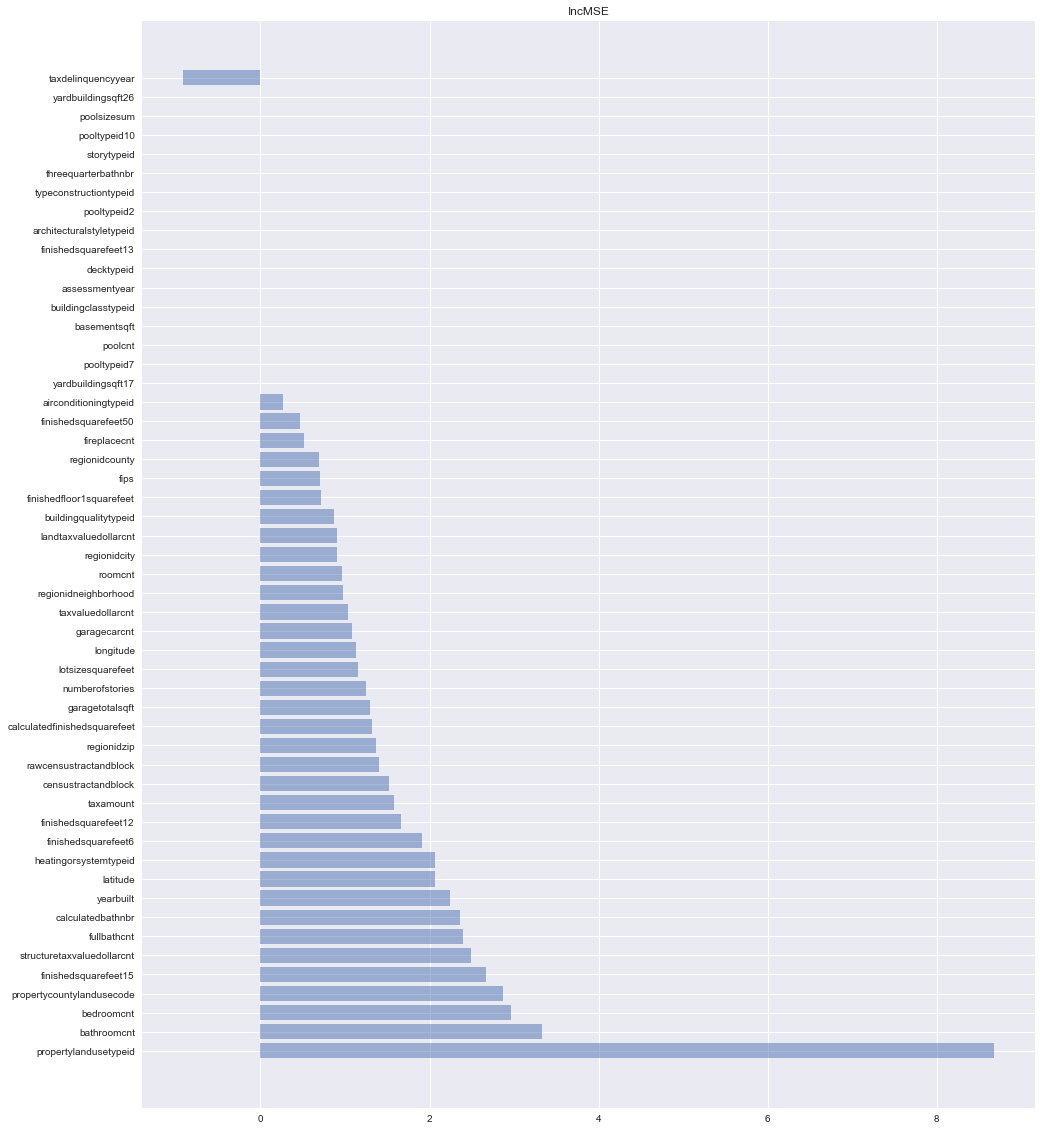

In [4]:
imp_features = []
filtered_importance_dfs = []
features_to_keep = ["Unnamed: 0","MeanDecreaseAccuracy","MeanDecreaseGini"]

for i in importance_dfs:
    if len(i.columns) > 3:
        j = i[features_to_keep]
    else:
        j = i
    j.columns = ["Unnamed: 0", "%IncMSE", "IncNodePurity"]
    filtered_importance_dfs.append(j)
        
for df1 in filtered_importance_dfs:
    #df1 = df1.sort_values(by = ["%IncMSE"])
    df1 = df1.sort_values(by = ["%IncMSE"],ascending=False).reset_index()

    # Plot importance
    a = df1["Unnamed: 0"].values
    #b = df1["IncNodePurity"].values
    b = df1["%IncMSE"].values
    names = np.ndarray.tolist(a)
    imp = np.ndarray.tolist(b)
    y_pos = np.arange(len(names))
    plt.figure(figsize=(16,20))
    plt.barh(y_pos,imp, align='center', alpha=0.5)
    plt.yticks(y_pos, names);
    plt.title("IncMSE")
    imp_features.append(list(df1["Unnamed: 0"].ix[0:14].values))

Since some of the features have strings as values (propertycountylandusecode), they are removed

In [7]:
# removing non-numeric features
for i in range(len(imp_features)):
    if 'propertycountylandusecode' in imp_features[i]:
        imp_features[i].remove('propertycountylandusecode')    

# 2. Selection of variables based on importance and %NAN  

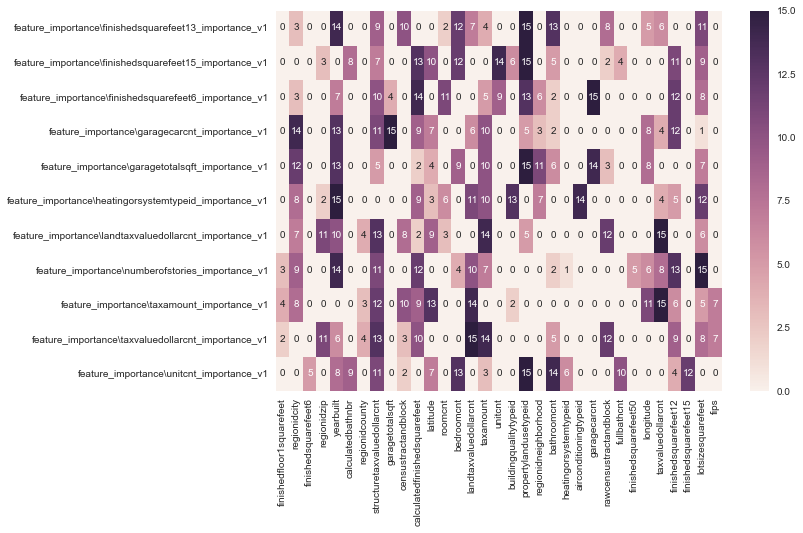

In [8]:
# create sets for features
a = Set()

for i in imp_features:
    for element in i:
        a.update([element])
    
a = list(a)    
b = {}

for i in range(0, len(a)):
    b[a[i]] = i

confusion_matrix = []    
    
for i in imp_features:
    temp = [0]*len(a)
    for j in range(0, len(i)):
        temp[b[i[j]]] = 16 - (j + 1)
    confusion_matrix.append(temp)
    
final_sum = list(np.sum(confusion_matrix, axis=0))

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in feature_list],
                  columns = [i for i in a])

plt.figure(figsize = (10,7))

sns.heatmap(df_cm, annot=True)

The above plot ranks the importance of each variable in the global list of important variables (34). This shows the relative importance of all variables and their cumulative importance towards all the target variables. If we take the column sum (as done in the next cell), we can quantatively select the variables which are important for all the target variables. Thus we can start focusing in a top down approach and fill the missing target fields in sequence. 

Note: Target Variable - Row Names (Missing Fields) 

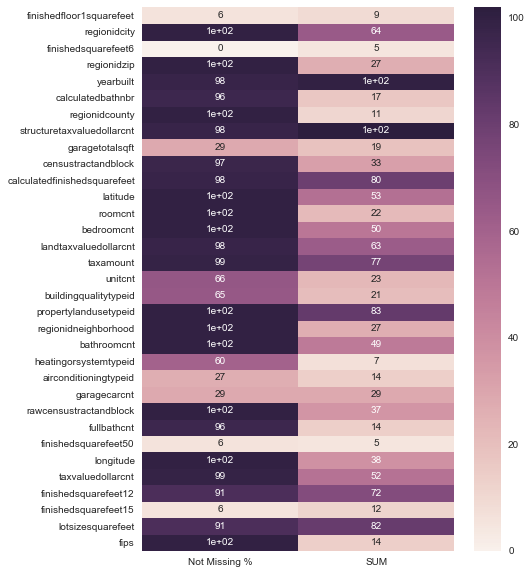

In [10]:
temp_frame_laks = df.isnull().sum(axis=0)
feature_list_laks = temp_frame_laks.index.values
null_percentage = temp_frame_laks.values/3064055.

feature_list_laks = list(feature_list_laks)
null_percentage = list(null_percentage)

nan_values = []
for i in a:
    temp_index = feature_list_laks.index(i)
    nan_values.append(int(100.0 - round(null_percentage[temp_index]*100, 1)))
    
transpose = map(list, zip(*[nan_values, final_sum]))    
    
df_nan = pd.DataFrame(transpose, index = [i for i in a],
                  columns = ["Not Missing %", "SUM"])

plt.figure(figsize = (7,10))

sns.heatmap(df_nan, annot=True)

The above plot shows the sum of importance for each feature and % of filled valules (opposite of %NANs) in the data set. We would start filling the fields which are dark on both scales. That would mean the most important features with least amount of NANs first and so on. 

In [11]:
nan_dict = dict(zip(a, nan_values))

In [32]:
filtered_imp_features = []

###############################################
NAN_THRESHOLD = 90  
###############################################

for i in imp_features:
    tmp = []
    for j in i:
        if nan_dict[j] > NAN_THRESHOLD:
            tmp.append(j)
    filtered_imp_features.append(tmp)

    
actual_names = [i.split("_")[0] for i in feature_list]
    
final_dict = dict(zip(actual_names, filtered_imp_features))

print final_dict

{'garagecarcnt': ['regionidcity', 'yearbuilt', 'finishedsquarefeet12', 'structuretaxvaluedollarcnt', 'taxamount', 'calculatedfinishedsquarefeet', 'longitude', 'latitude', 'landtaxvaluedollarcnt', 'propertylandusetypeid', 'taxvaluedollarcnt', 'regionidneighborhood', 'bathroomcnt', 'lotsizesquarefeet'], 'numberofstories': ['lotsizesquarefeet', 'yearbuilt', 'finishedsquarefeet12', 'calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'regionidcity', 'taxvaluedollarcnt', 'taxamount', 'longitude', 'bedroomcnt', 'bathroomcnt'], 'taxamount': ['taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'latitude', 'structuretaxvaluedollarcnt', 'longitude', 'censustractandblock', 'calculatedfinishedsquarefeet', 'regionidcity', 'fips', 'finishedsquarefeet12', 'lotsizesquarefeet', 'regionidcounty'], 'finishedsquarefeet6': ['calculatedfinishedsquarefeet', 'propertylandusetypeid', 'finishedsquarefeet12', 'roomcnt', 'structuretaxvaluedollarcnt', 'lotsizesquarefeet', 'yearbuilt', '

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

target = ["landtaxvaluedollarcnt","taxamount","taxvaluledollarcnt"]
j = 0

for target_var in target:
    features = tax_imp_features[j]
    features.remove(target)
    max_num_features = len(features)
    X = df[features].as_matrix()
    y = df[target].values
    sc = StandardScaler()
    X_new = sc.fit_transform(X,y=y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    clf = SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, \
              shrinking=True, cache_size=200, verbose=False, max_iter=-1)
    
    clf.fit(X_train, y_train) 

    
    

ValueError: invalid literal for float(): 010E

In [110]:
df_del_me = df[features]
df_del_me.isnull().sum(axis=0)

taxvaluedollarcnt                31114
taxamount                        19819
structuretaxvaluedollarcnt       43925
rawcensustractandblock               0
regionidzip                          0
yearbuilt                        49247
latitude                             0
censustractandblock              64294
regionidcity                         0
lotsizesquarefeet               274812
propertylandusetypeid                0
regionidcounty                       0
propertycountylandusecode          841
roomcnt                             38
calculatedfinishedsquarefeet     44789
dtype: int64

In [120]:
target = ["landtaxvaluedollarcnt","taxamount","taxvaluledollarcnt"]
features = tax_imp_features[0]
#features.remove(target)
features
a = [x for x in features if x not in target]
a

['taxvaluedollarcnt',
 'structuretaxvaluedollarcnt',
 'rawcensustractandblock',
 'regionidzip',
 'yearbuilt',
 'latitude',
 'censustractandblock',
 'regionidcity',
 'lotsizesquarefeet',
 'propertylandusetypeid',
 'regionidcounty',
 'roomcnt',
 'calculatedfinishedsquarefeet']

In [121]:
features

['taxvaluedollarcnt',
 'taxamount',
 'structuretaxvaluedollarcnt',
 'rawcensustractandblock',
 'regionidzip',
 'yearbuilt',
 'latitude',
 'censustractandblock',
 'regionidcity',
 'lotsizesquarefeet',
 'propertylandusetypeid',
 'regionidcounty',
 'roomcnt',
 'calculatedfinishedsquarefeet']